# Song lyrics exploration - Part 3: Lexical diversity

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words

from nlp import tokenize

# Pre-processing

1. **Load data**

1. **Tokenize text data**

1. **Combine songs from same band**

1. **Split lyrics into words**

In [2]:
def get_genres(data):
    columns = [col for col in data.columns if 'genre_' in col]
    genres = [re.sub(r"^genre\_", "", col) for col in columns]
    return genres, columns


def get_bands(data):
    genres, genre_cols = get_genres(data)
    # Combine songs from same band
    band_genres = data.groupby('band_name')[genre_cols].max()
    band_lyrics = data.groupby('band_name').song_darklyrics.sum()
    bands = pd.concat((band_genres, band_lyrics), axis=1)
    bands.columns = genres + ['lyrics']
    bands['words'] = bands.lyrics.apply(tokenize)
    return bands


def get_songs(data):
    genres, genre_cols = get_genres(data)
    songs = data[genre_cols + ['song_darklyrics']].copy()
    songs.columns = genres + ['lyrics']
    songs['words'] = songs.lyrics.apply(tokenize)
    return songs

# Lexical diversity measures

$$
\begin{split}
&LD_{TTR} &= \frac{V}{N} &\hspace{1cm} (\textrm{type-token ratio})\\
&LD_{rootTTR} &= \frac{V}{\sqrt{N}} &\hspace{1cm} (\textrm{root type-token ratio})\\
&LD_{logTTR} &= \frac{\log{V}}{\log{N}} &\hspace{1cm} (\textrm{logarithmic type-token ratio})\\
\end{split}
$$

Measure of Textual Lexical Diversity: [McCarthy and Jarvis (2010)](https://doi.org/10.3758/BRM.42.2.381)

In [52]:
df_bands.loc['A Forest of Stars'].words

['silence',
 'like',
 'rage',
 'in',
 'myriad',
 'of',
 'the',
 'wind',
 'all',
 'light',
 'now',
 'absent',
 'as',
 'the',
 'howl',
 'no',
 'solace',
 'in',
 'the',
 'even',
 'the',
 'afraid',
 'to',
 'rise',
 'around',
 'here',
 'ice',
 'cold',
 'as',
 'far',
 'as',
 'the',
 'eye',
 'can',
 'see',
 'relentless',
 'winter',
 'restraining',
 'the',
 'new',
 'mourning',
 'frozen',
 'in',
 'thought',
 'whilst',
 'seeking',
 'got',
 'scalded',
 'by',
 'given',
 'the',
 'cold',
 'shoulder',
 'by',
 'winter',
 'watched',
 'the',
 'world',
 'go',
 'shifting',
 'slowly',
 'from',
 'here',
 'to',
 'going',
 'in',
 'the',
 'direction',
 'of',
 'but',
 'neither',
 'here',
 'nor',
 'there',
 'now',
 'a',
 'taste',
 'of',
 'blood',
 'in',
 'all',
 'the',
 'around',
 'for',
 'a',
 'shot',
 'of',
 'winter',
 'in',
 'my',
 'it',
 'caught',
 'my',
 'throat',
 'afire',
 'on',
 'the',
 'way',
 'down',
 'wrought',
 'iron',
 'further',
 'countless',
 'rhyme',
 'boring',
 'it',
 'very',
 'sunny',
 'that',


In [201]:
def MTLD_forward(words, threshold=0.720, verbose=False):
    def TTR(x):
        return len(set(x)) / len(x)
    factor = 0
    segment = []
    i = 0
    while i < len(words):
        segment.append(words[i])
        segTTR = TTR(segment)
        if verbose:
            print(i, segment, factor, segTTR)
        if segTTR <= threshold:
            segment = []
            factor += 1
        i += 1
    segment = words[i:]
    if len(segment) > 0:
        segTTR = TTR(segment)
        factor += (1.0 - segTTR) / (1.0 - size)
    mtld = factor / len(words)
    return mtld


def MTLD(words, threshold=0.720, verbose=False):
    if len(words) == 0:
        return 0.0
    forward = MTLD_forward(words, threshold=threshold, verbose=verbose)
    reverse = MTLD_forward(words[::-1], threshold=threshold, verbose=verbose)
    return 0.5 * (forward + reverse)

In [96]:
MTLD('of the people by the people for the people'.split(), verbose=True)

0 ['of'] 0 1.0
1 ['of', 'the'] 0 1.0
2 ['of', 'the', 'people'] 0 1.0
3 ['of', 'the', 'people', 'by'] 0 1.0
4 ['of', 'the', 'people', 'by', 'the'] 0 0.8
5 ['of', 'the', 'people', 'by', 'the', 'people'] 0 0.6666666666666666
6 ['for'] 1 1.0
7 ['for', 'the'] 1 1.0
8 ['for', 'the', 'people'] 1 1.0
0 ['people'] 0 1.0
1 ['people', 'the'] 0 1.0
2 ['people', 'the', 'for'] 0 1.0
3 ['people', 'the', 'for', 'people'] 0 0.75
4 ['people', 'the', 'for', 'people', 'the'] 0 0.6
5 ['by'] 1 1.0
6 ['by', 'people'] 1 1.0
7 ['by', 'people', 'the'] 1 1.0
8 ['by', 'people', 'the', 'of'] 1 1.0


0.1111111111111111

In [108]:
MTLD(df_bands.loc['A Forest of Stars'].words)

0.017978003384094755

In [173]:
def cumulative_TTR(words):
    def TTR(x):
        return len(set(x)) / len(x)
    out = [TTR(words[: i + 1]) for i in range(len(words))]
    return out

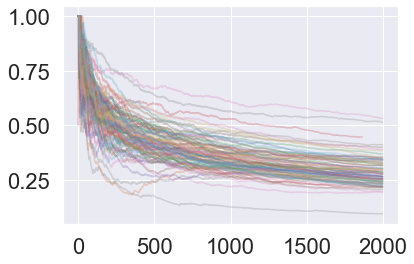

In [221]:
for i in range(0, 1000, 10):
    plt.plot(cumulative_TTR(df_bands.iloc[i].words[:2000]), alpha=0.3)
plt.show()

In [217]:
def get_lexical_diversity(data):
    N = data.words.apply(len)
    V = data.words.apply(lambda x: len(set(x)))
    data['N'] = N
    data['V'] = V
    data['TTR'] = V / N
    data['rootTTR'] = V / np.sqrt(N)
    data['logTTR'] = np.log(V) / np.log(N)
    data['mtld'] = data.words.apply(MTLD, threshold=0.5)
    data['logmtld'] = np.log(data['mtld'])
    return data[data.N > 0]

In [218]:
df = pd.read_csv('songs-10pct.csv')
df_bands = get_bands(df)
df_songs = get_songs(df)
df_bands = get_lexical_diversity(df_bands)
df_songs = get_lexical_diversity(df_songs)

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Histograms

In [238]:
def plot_histograms(data):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of heavy metal artists", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    logNmin, logNmax = np.log10(data.N.min()), np.log10(data.N.max())
    logbins = np.logspace(logNmin, logNmax, 20)
    data.N.hist(bins=logbins, edgecolor='k', ax=ax)
    ax.set_xscale('log')
    ax.set_title("Vocabulary sizes")
    ax.set_xlabel("N (tokens)")
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

    ax = axes[1]
    data.TTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{TTR} = V/N}$")

    ax = axes[2]
    data.rootTTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Root type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")

    ax = axes[3]
#     data.corrTTR.hist(bins=20, edgecolor='k', ax=ax)
#     ax.set_title("Corrected type-token ratio")
#     ax.set_xlabel("$\mathrm{LD_{corrTTR}} = \sqrt{V/2N}$")
    data.logTTR.hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")

    ax = axes[4]
#     data.msttr[data.msttr > 1].hist(bins=30, edgecolor='k', ax=ax)
#     ax.set_title("Mean segment type-token ratio")
#     ax.set_xlabel("$\mathrm{MSTTR}$")

    ax = axes[5]
#     data.dugast[data.dugast < np.inf].hist(bins=30, edgecolor='k', ax=ax)
#     ax.set_title("Dugast uber index")
#     ax.set_xlabel("$\mathrm{LD_{Dugast}} = (\log N)^2 / log(N/V)$")
    data.logmtld[data.logmtld > -np.inf].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    for ax in axes:
        ax.set_ylabel("Artists", rotation=0, labelpad=40)
        ax.grid(None)
        ax.grid(axis='y', color='k')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

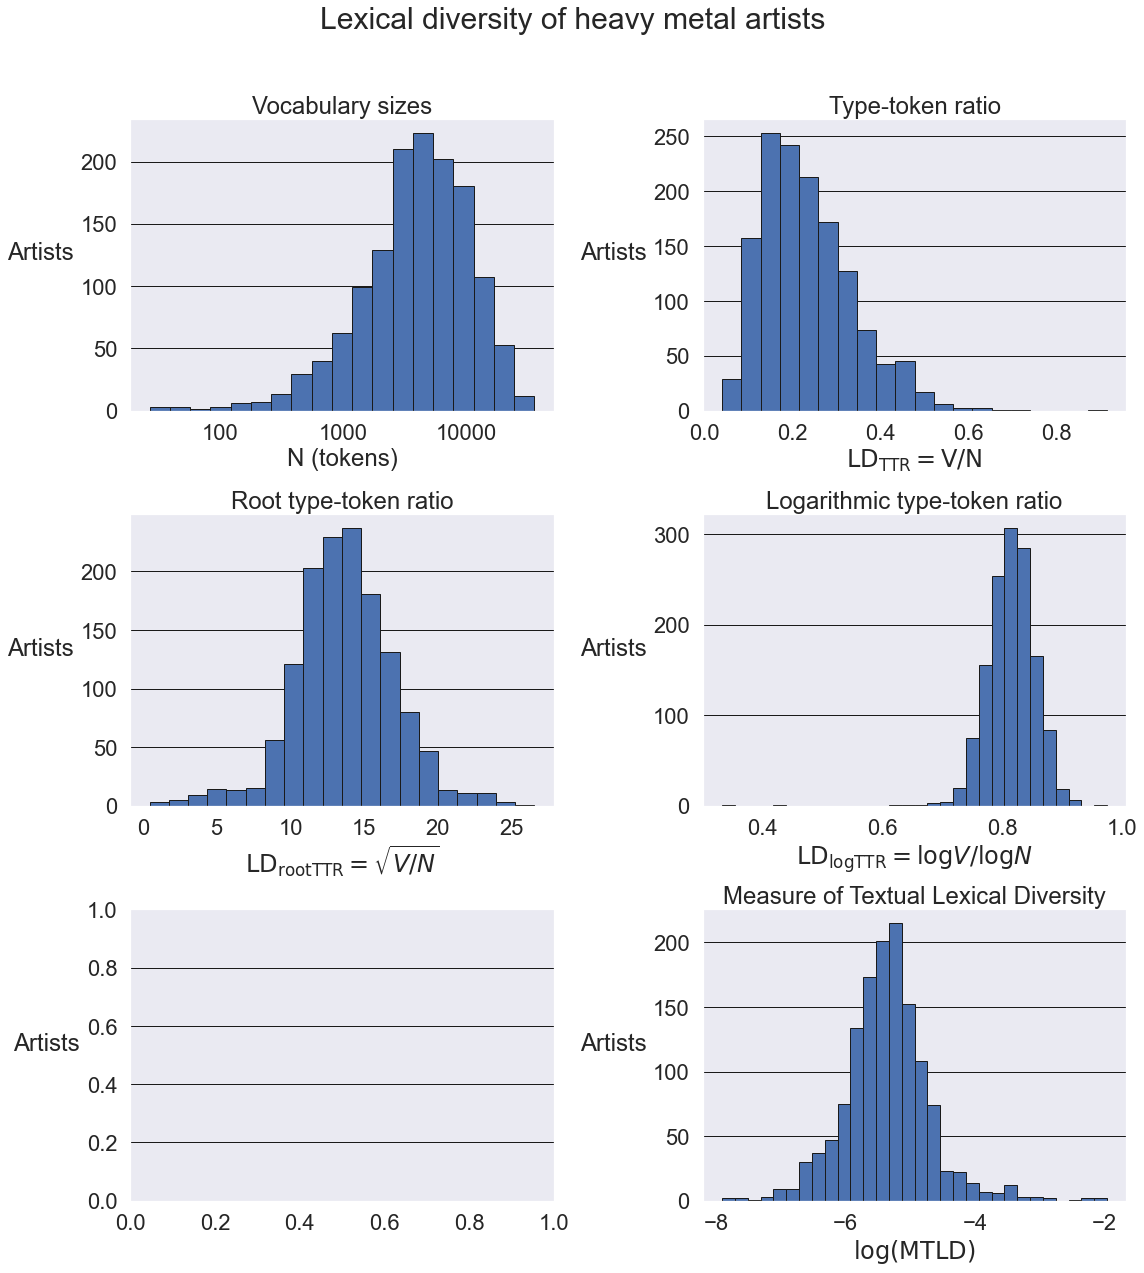

In [239]:
plot_histograms(df_bands)

# Violin plots

In [236]:
def plot_violinplots(data, figsize=(16, 18)):

    def violinplot(col, ax):
        violindata = []
        labels = data.columns[:list(data.columns).index('lyrics')]
        for label in labels:
            values = data[data[label] == 1][col]
            values = values[(values > -np.inf) & (values < np.inf)]
            violindata.append((label, values))
        violindata.sort(key=lambda x: -x[1].median())
        plot_labels, plot_data = zip(*violindata)
        sns.violinplot(data=plot_data, cut=0, orient='h', ax=ax, color='c')
        ax.set_yticklabels(plot_labels)
        return

    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    violinplot('N', ax)
    ax.set_title("Word counts")
    ax.set_xlabel("N (tokens)")

    ax = axes[1]
    violinplot('V', ax)
    ax.set_title("Unique word counts")
    ax.set_xlabel("V (types)")

    ax = axes[2]
    violinplot('TTR', ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

    ax = axes[3]
#     violinplot('corrTTR', ax)
#     ax.set_title("Corrected type-token ratio")
#     ax.set_xlabel(r"$\mathrm{LD_{corrTTR}}$")
    violinplot('logTTR', ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[4]
#     violinplot('msttr', ax)
#     ax.set_title("Mean segment type-token ratio")
#     ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[5]
#     violinplot('dugast', ax)
#     ax.set_title("Dugast uber index")
#     ax.set_xlabel(r"$\mathrm{LD_{dugast}}$")
    violinplot('logmtld', ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

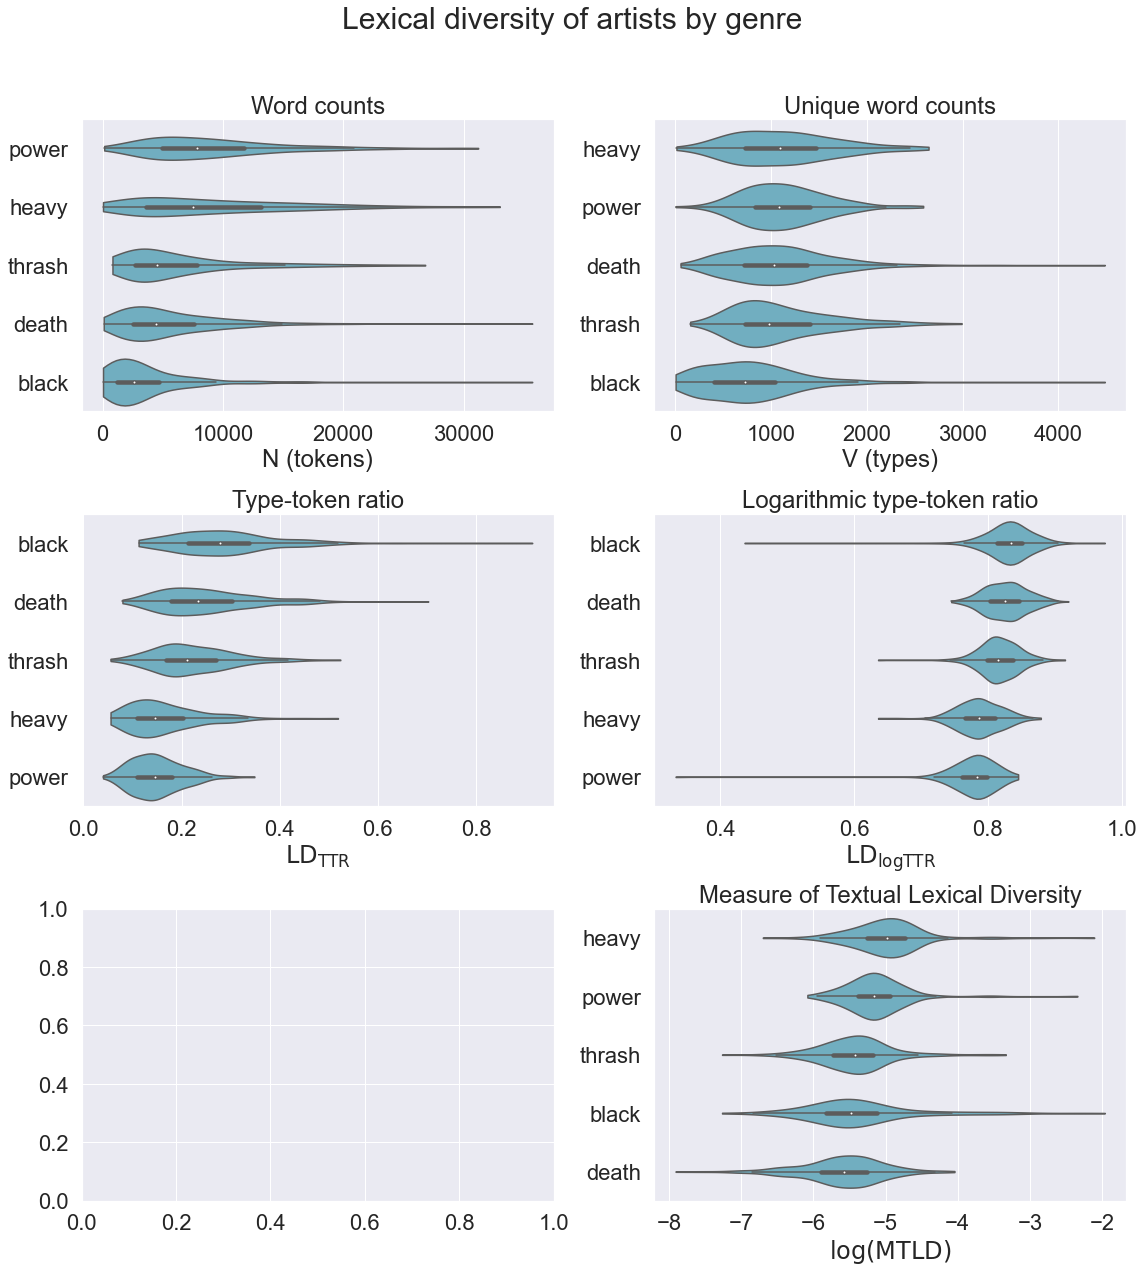

In [237]:
plot_violinplots(df_bands, figsize=(16, 18))

# Scatter plots

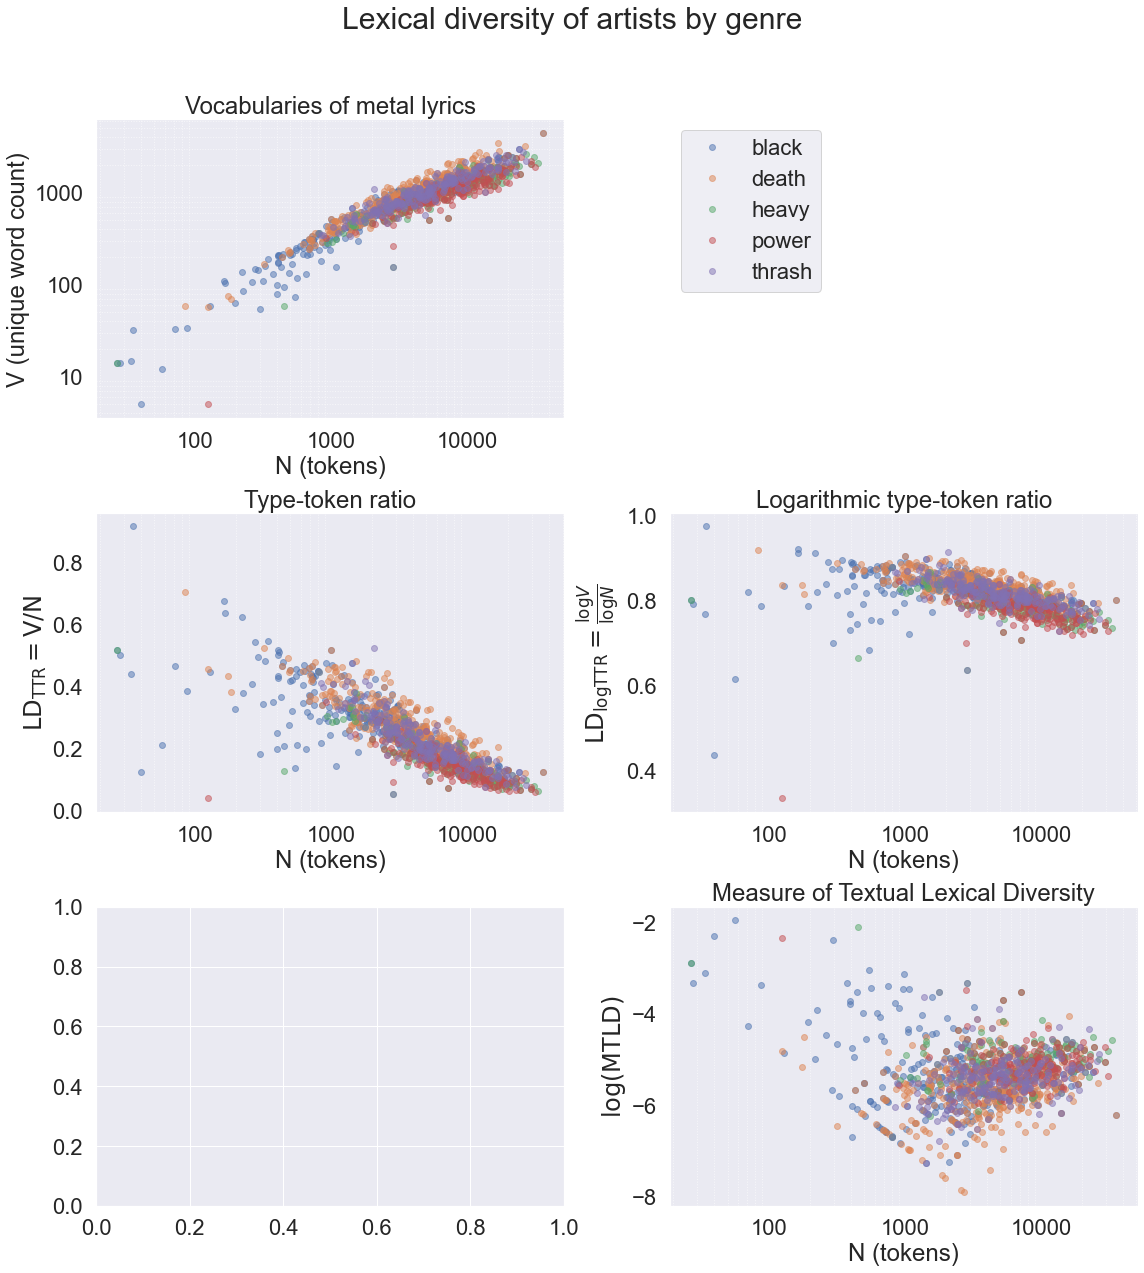

In [235]:
genres = df_bands.columns[:list(df_bands.columns).index('lyrics')]

def lexical_diversity_scatterplot(col, ax):
    for genre in genres:
        subset = df_bands[df_bands[genre] > 0]
        ax.plot(subset['N'], subset[col], 'o', markeredgewidth=1, alpha=0.5, label=genre)
    ax.set_xlabel("N (tokens)")
    ax.grid(axis='both', which='major')
    ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
    return

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
axes = axes.flatten()

ax = axes[0]
lexical_diversity_scatterplot('V', ax)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_ylabel("V (unique word count)")

ax = axes[1]
ax.axis('off')
for genre in genres:
    ax.plot([], [], 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.legend(frameon=True, loc='upper left')

ax = axes[2]
lexical_diversity_scatterplot('TTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Type-token ratio")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$")

ax = axes[3]
lexical_diversity_scatterplot('logTTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Logarithmic type-token ratio")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$")

ax = axes[4]

ax = axes[5]
lexical_diversity_scatterplot('logmtld', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Measure of Textual Lexical Diversity")
ax.set_ylabel(r"$\log(\mathrm{MTLD})$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Violin plots with expanded genres dataset

In [12]:
df_exp = pd.read_csv('songs-1pct.csv')
df_exp_bands = get_bands(df_exp)
df_exp_bands = get_lexical_diversity(df_exp_bands)

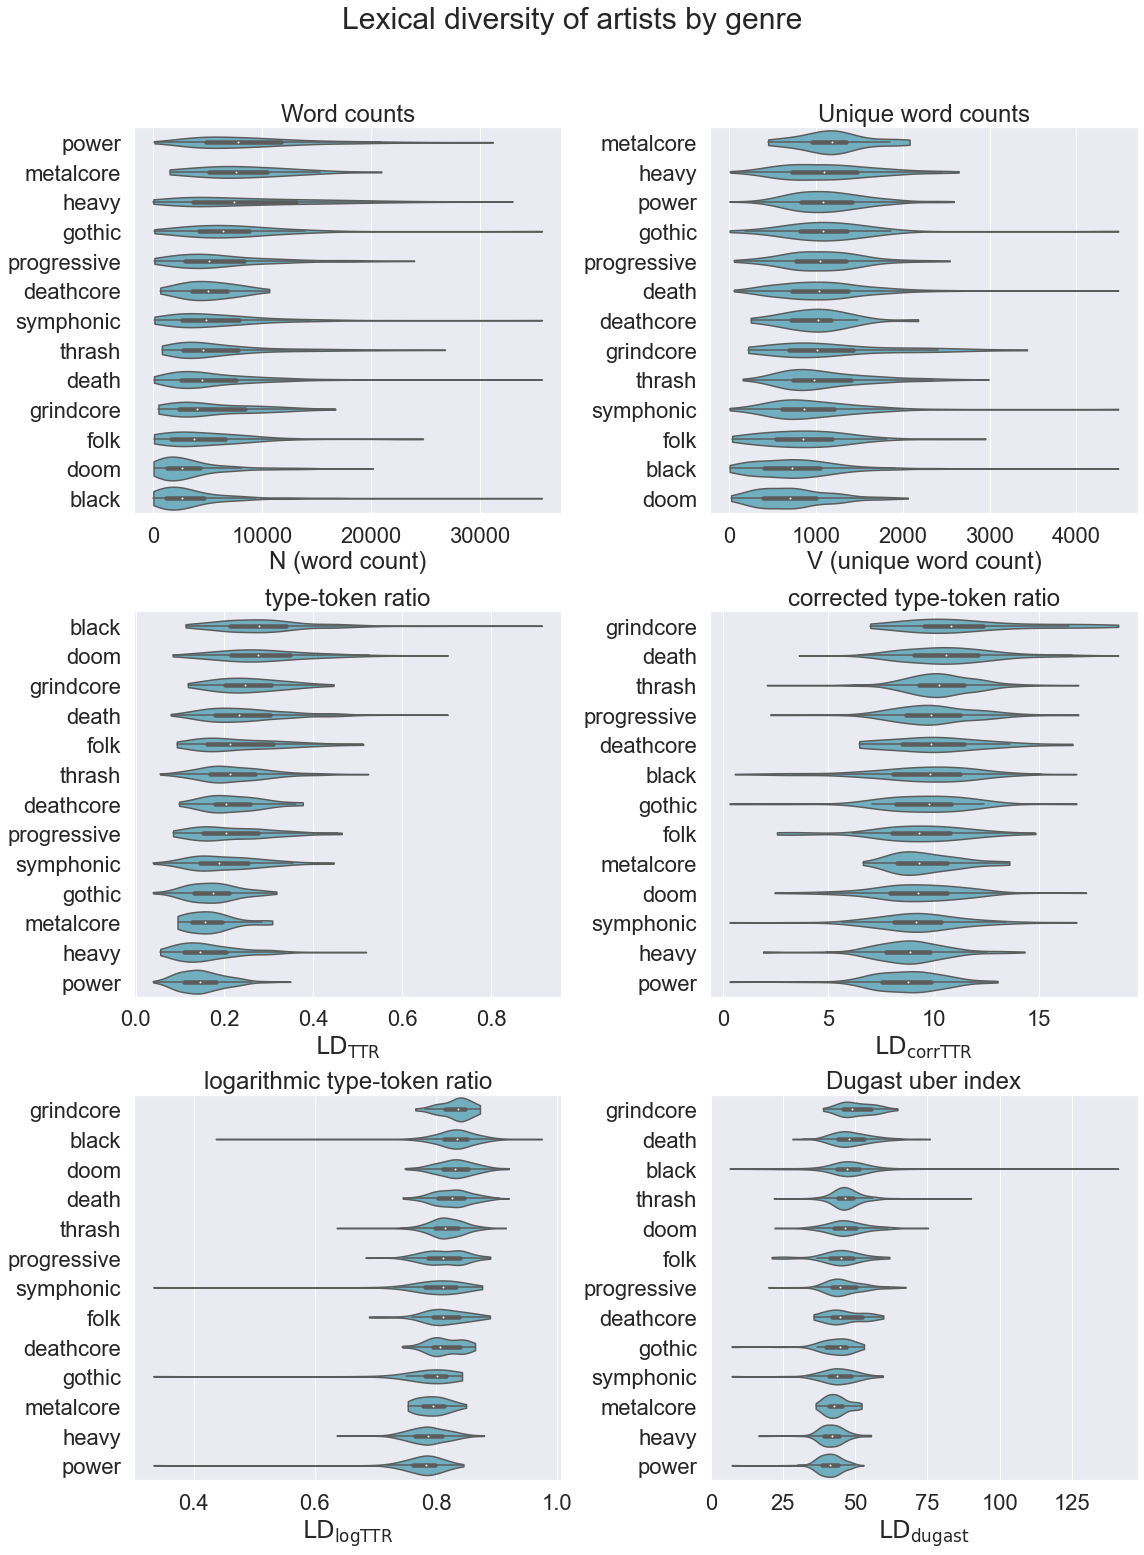

In [20]:
plot_violinplots(df_exp_bands, figsize=(16, 22))